# Experimental results

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tables as tb

## Initial data

In [2]:
farm_names = ['Oahu', 'Almeria']
farm_names_es = ['Oahu', 'Almería']
input_paths = []
sensor_names = {}
sensor_latitudes = {}
sensor_longitudes = {}
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    input_path = f'../data/input/{farm_name}/sensors_data.h5'
    input_paths.append(input_path)
    input_table = tb.open_file(input_path, 'r')
    info_group = input_table.get_node('/', 'info')
    sensor_names_aux: tb.Array = input_table.get_node(info_group, 'sensor_names')
    sensor_names[farm_name] = [name.decode() for name in sensor_names_aux]
    sensor_latitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_latitudes')
    sensor_longitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_longitudes')
    input_table.close()
output_paths = ['../data/output/DataCenter/Oahu/oahu.h5', '../data/output/DataCenter/Almeria/almeria.h5']

## Monitoring

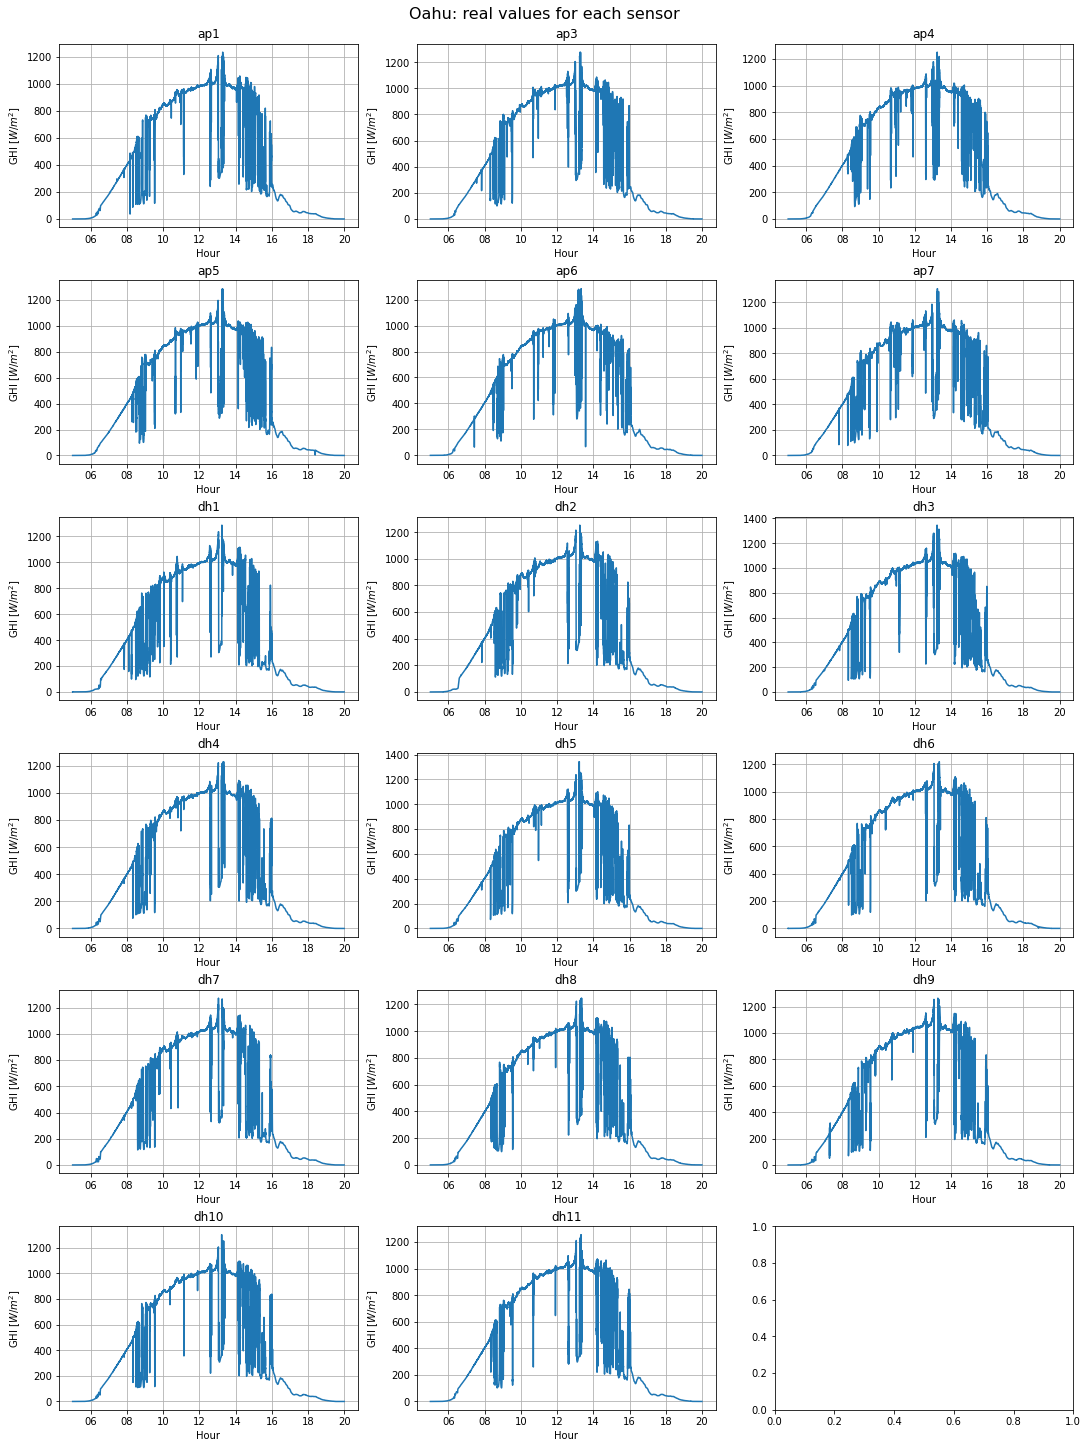

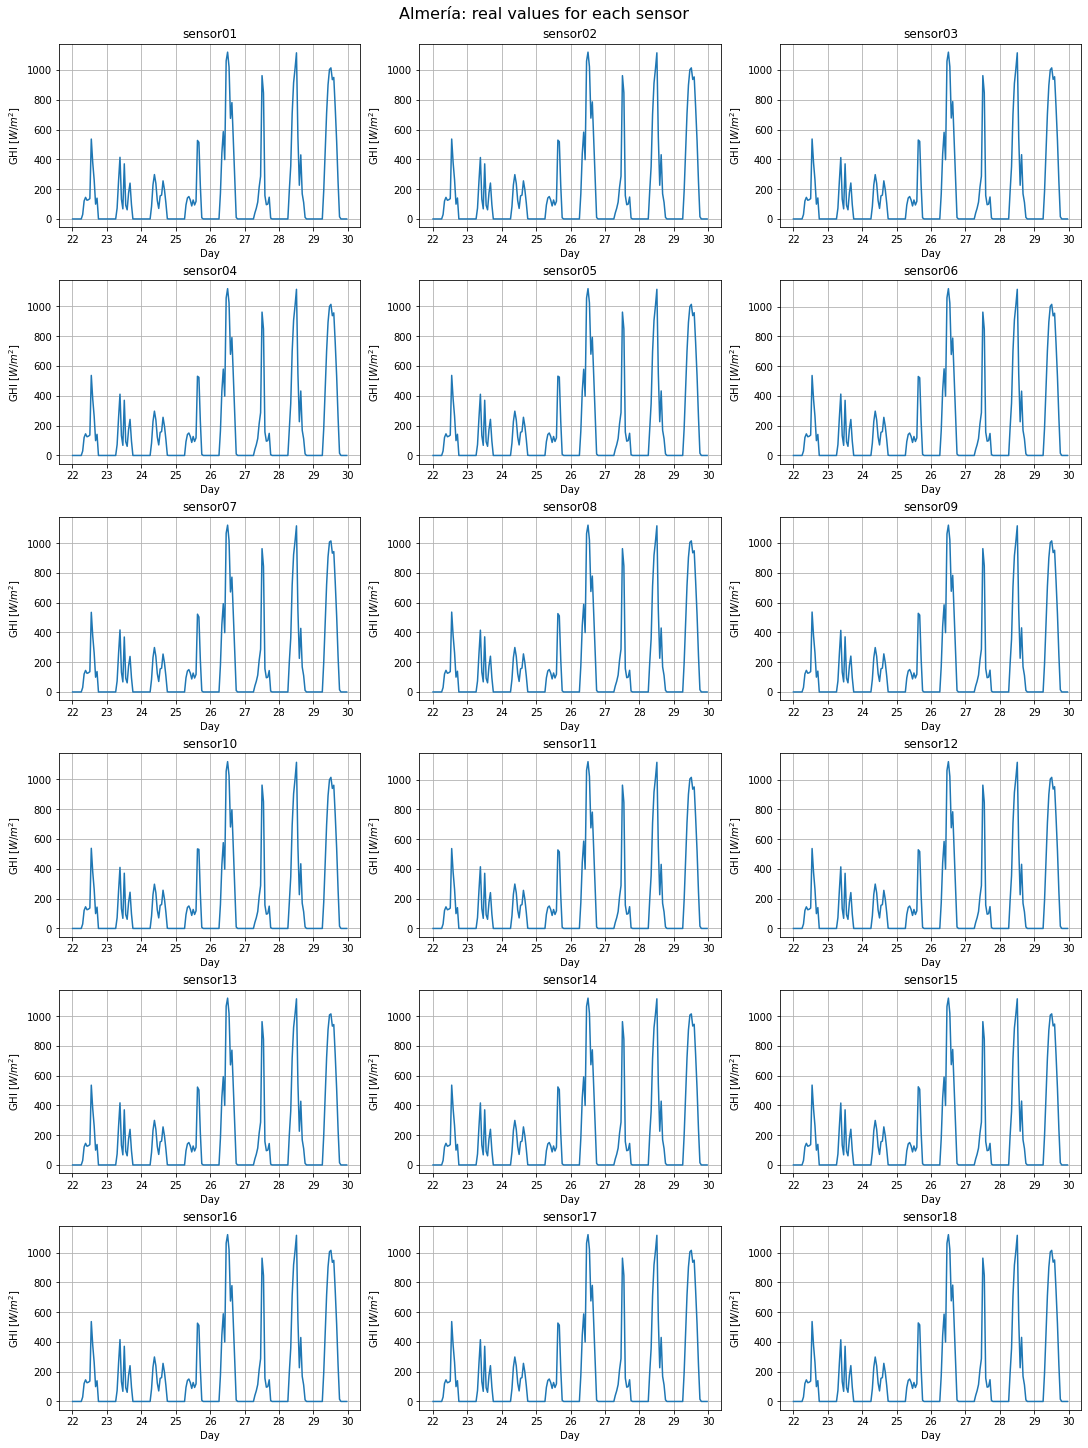

In [28]:
start_dts = [dt.datetime.strptime("2010-06-27 00:00:00", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-22 00:00:00", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-06-27 23:59:59", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-29 23:59:59", "%Y-%m-%d %H:%M:%S")]
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    output_path = output_paths[f]
    output_table = tb.open_file(output_path, 'r')
    fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
    fig.suptitle(f'{farm_names_es[f]}: real values for each sensor', fontsize=16)
    for s in range(len(sensor_names[farm_name])):
        sensor_table = output_table.get_node(f'/DataCenter/{farm_name}/{sensor_names[farm_name][s]}')
        df = pd.DataFrame.from_records(sensor_table.read_where(f"(timestamp>={start_dts[f].timestamp()}) & (timestamp<{stop_dts[f].timestamp()})"))
        df['timestamp'] = [dt.datetime.fromtimestamp(x) for x in df['timestamp']]
        ax[s//3,s%3].set_title(sensor_names[farm_name][s])
        ax[s//3,s%3].plot(df.timestamp, df.radiation)
        if farm_name == 'Oahu':
            ax[s//3,s%3].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        else:
            ax[s//3,s%3].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        ax[s//3,s%3].grid()
        ax[s//3,s%3].set_ylabel('GHI $[W/m^2]$')
        if farm_name == 'Oahu':
            ax[s//3,s%3].set_xlabel('Hour') #, fontsize=12)
        else:
            ax[s//3,s%3].set_xlabel('Day') #, fontsize=12)
    fig.savefig(f'{farm_names[f]}-monitoring.png', dpi=400, bbox_inches='tight')
    output_table.close()

## Prediction

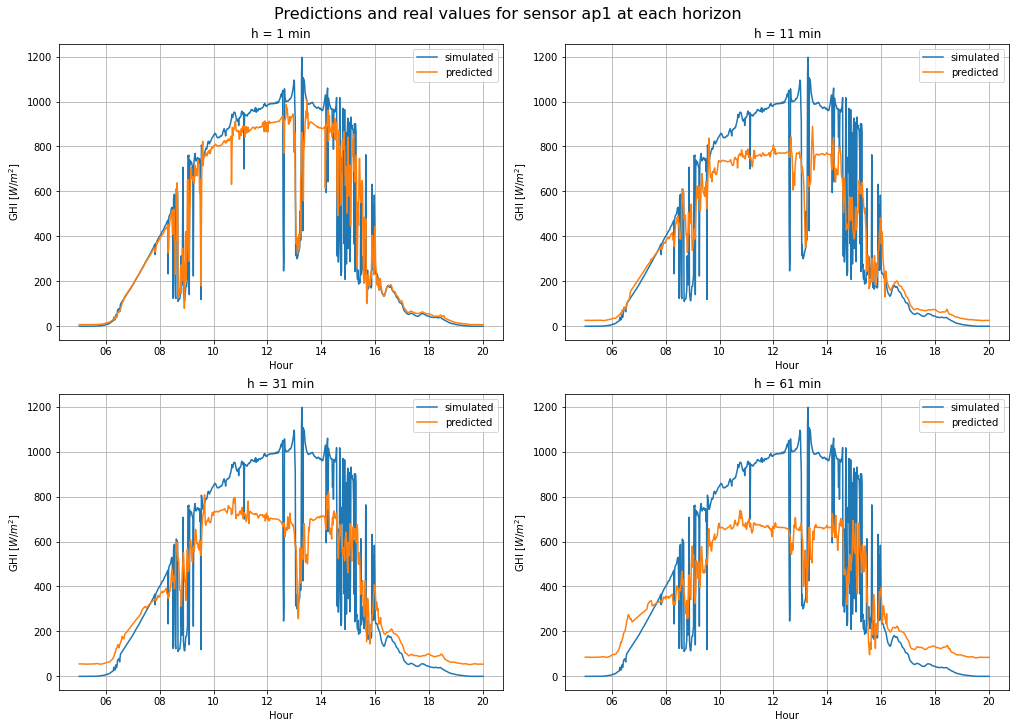

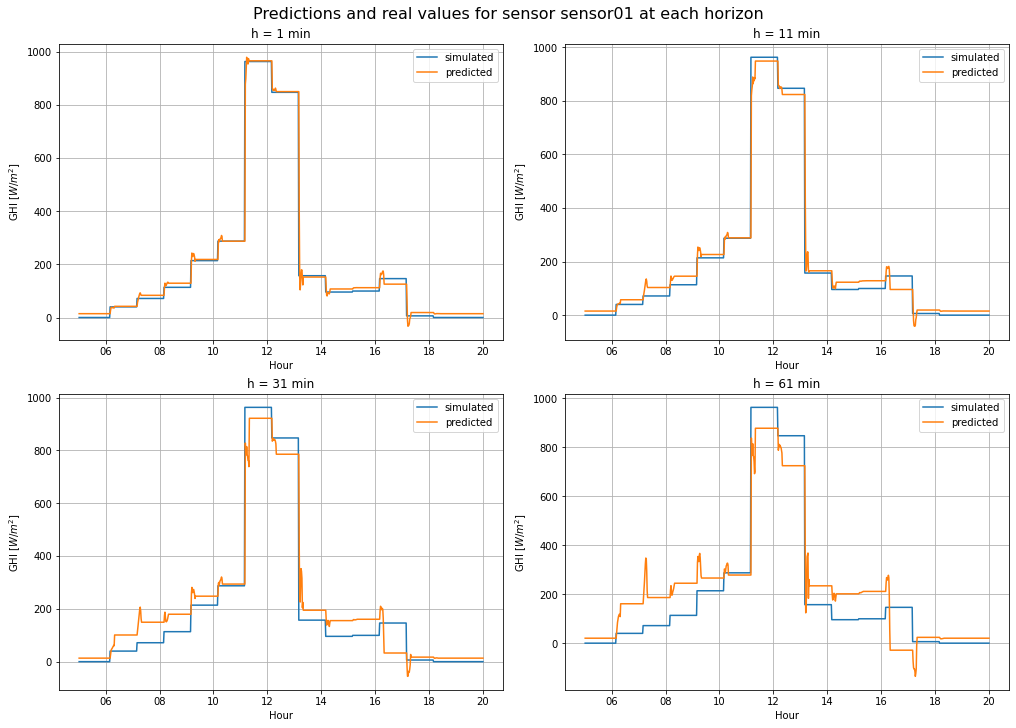

In [3]:
start_dts = [dt.datetime.strptime("2010-06-27 05:00:00", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-27 05:00:00", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-06-27 20:00:00", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-27 20:00:00", "%Y-%m-%d %H:%M:%S")]
for f in range(len(start_dts)):
    farm_name = farm_names[f]
    pred_dir = f'../data/output/DataCenter/{farm_name}'
    data_path = f'{pred_dir}/prediction-input.h5'
    prediction_path = f'{pred_dir}/prediction-output.h5'
    n_sensors = len(sensor_names[farm_name])
    n_horizons = 4
    n = stop_dts[f].strftime('%Y-%m-%d')
    with tb.open_file(prediction_path, 'r') as h5_preds, tb.open_file(data_path, 'r') as h5_data:
        timestamps = h5_preds.root.DataCenter[farm_name][n]._v_children.keys()
        timestamps = list(timestamps)
        preds = np.empty((len(timestamps), n_sensors, n_horizons))
        data = np.empty((len(timestamps), n_sensors))
        data_table = h5_data.get_node(f"/DataCenter/{farm_name}/{n}")
        data_idx = 0
        for idx, t in enumerate(timestamps):
            preds[idx] = h5_preds.root.DataCenter[farm_name][n][t][:]
            while data_idx < len(data_table) and data_table[data_idx][0] < dt.datetime.strptime(f'{n}  {t}', '%Y-%m-%d %H:%M:%S').timestamp():
                data_idx += 1
            data[idx] = h5_data.root.DataCenter[farm_name][n][data_idx,1:]
        sensors = h5_data.root.DataCenter[farm_name]._v_attrs['columns'][1:]
    times = [pd.to_datetime(d) for d in timestamps]
    # Print some statistics:
    # Sensor, horizon, MAE, MAPE
    mae = np.empty((n_sensors, n_horizons))
    mape = np.empty((n_sensors, n_horizons))
    for s in range(n_sensors):
        for h in range(n_horizons):
            mae[s][h] = metrics.mean_absolute_error(preds[:,s,h], data[:,s])
            mape[s][h] = metrics.mean_absolute_percentage_error(preds[:,s,h], data[:,s])
    # Plot predictions and real values for each sensor
    sensor = 0
    fig, ax = plt.subplots(2,2, figsize=(14,10),constrained_layout = True)
    fig.suptitle(f'Predictions and real values for sensor {sensor_names[farm_name][sensor]} at each horizon', fontsize=16)
    for idx,h in enumerate(['1 min','11 min','31 min','61 min']):
        ax[idx//2,idx%2].set_title(label=f'h = {h}, MAE = {mae[sensor,idx]:.2f}, MAPE = {mape[sensor,idx]:.2f}')
        ax[idx//2,idx%2].plot(times, data[:,sensor], label='simulated')
        ax[idx//2,idx%2].plot(times, preds[:,sensor,idx], label='predicted')
        ax[idx//2,idx%2].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax[idx//2,idx%2].grid()
        ax[idx//2,idx%2].legend()
        ax[idx//2,idx%2].set_ylabel('GHI $[W/m^2]$')
        ax[idx//2,idx%2].set_xlabel('Hour') #, fontsize=12)
    plt.savefig(f'../data/output/DataCenter/{farm_name}/{farm_name}-predictions.png', dpi=400, bbox_inches='tight')
